In [1]:
%load_ext autoreload
%autoreload 2

# ERA5 distance average weighted remapping

This notebook shows how to do distance average weighted remapping with the
the [Climate Data Operators](https://code.mpimet.mpg.de/projects/cdo) tool
and using the `geoglue` library to facilitate remapping.

We will be remapping ERA5 data to the higher resolution WorldPop data,
focussing on Vietnam:

In [2]:
import xarray as xr
from geoglue.era5 import ERA5
from geoglue.memoryraster import MemoryRaster

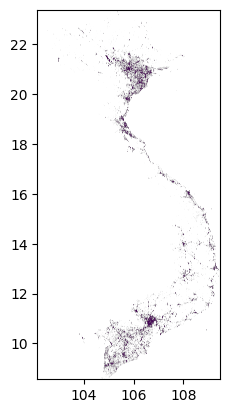

<Axes: >

In [3]:
population = MemoryRaster.read("../data/vnm_ppp_2020_UNadj_constrained.tif", crs="EPSG:4326")
population.plot()

In [4]:
population.shape

(17796, 8789)

We need to obtain the CDO grid specification to pass as a reference grid for remapping.
This can be obtained using the `cdo_grid` attribute of the `MemoryRaster` object.

In [5]:
print(population.cdo_grid)

gridtype=lonlat
xfirst=102.145416273
xinc=0.0008333333299579025
xsize=8789
yfirst=8.562916834
yinc=0.0008333333300179816
ysize=17796



The ERA5 class automatically crop the extents of the weather data based on the geometry (here Vietnam admin 2):

In [6]:
era5 = ERA5("../79a080c8aaa9b3f1d4808e650202035c.nc", ("VNM", 2), population)
era5

ERA5 VNM admin_level=2 statistic=daily_mean
filename  = '../79a080c8aaa9b3f1d4808e650202035c.nc'
variables = 2m_temperature

We can plot the `2m_temperature` data here:

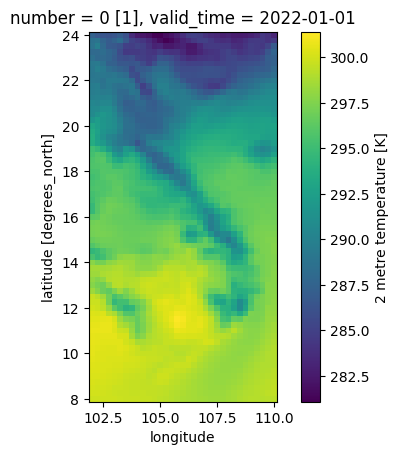

In [7]:
era5["t2m"].isel(valid_time=0).plot().axes.set_aspect('equal')

In [8]:
era5.to_netcdf("temperature.nc")
xr.open_dataset("temperature.nc")

<xarray.Dataset> Size: 3MB
Dimensions:     (valid_time: 365, latitude: 65, longitude: 33)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 520B 24.0 23.75 23.5 23.25 ... 8.5 8.25 8.0
  * valid_time  (valid_time) datetime64[ns] 3kB 2022-01-01 ... 2022-12-31
  * longitude   (longitude) float64 264B 102.0 102.2 102.5 ... 109.5 109.8 110.0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-23T10:15 GRIB to CDM+CF via cfgrib-0.9.1...

Before calling CDO, we will need to write out the CDO grid specification to a file,
and save the cropped temperature data to a NetCDF file. You will also need
the CDO binary present on your system:

- **macOS**: `brew install cdo`
- **Debian**: `apt install cdo`

In [11]:
from pathlib import Path
Path("template.nc").write_text(str(population.cdo_grid))

133

In [12]:
from cdo import Cdo
Cdo().remapdis("template.nc", input="temperature.nc", output="temperature-remapdis.nc")

Error in calling operator remapdis with:
>>> cdo -O -s -remapdis,template.nc temperature.nc temperature-remapdis.nc<<<
STDOUT:
STDERR:cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!

cdo    remapdis (Abort): Unsupported generic coordinates (Variable: t2m)!



CDOException: (returncode:1) cdi  warning (set_coordinates_varids): Coordinates variable number can't be assigned!

cdo    remapdis (Abort): Unsupported generic coordinates (Variable: t2m)!
